In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [5]:
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
observation = "data/obs/56412.76_GBT_1400"
processing_name = "singlefrequency"
# These are the highest-SNR GBT observations, as obtained from summary.ipynb
for s, o in [(72147.438642543886, '56412.76_GBT_1400'), 
             (68267.325089264225, '56321.01_GBT_1400'), 
             (67777.17230122973, '56142.50_GBT_1400'), 
             (66221.79141810436, '56234.25_GBT_1400'), 
             (60884.632224439782, '56506.42_GBT_1400'), 
             (49579.207341495159, '56690.92_GBT_1400'), 
             (45528.897719101544, '56527.34_GBT_1400')]:
    pass

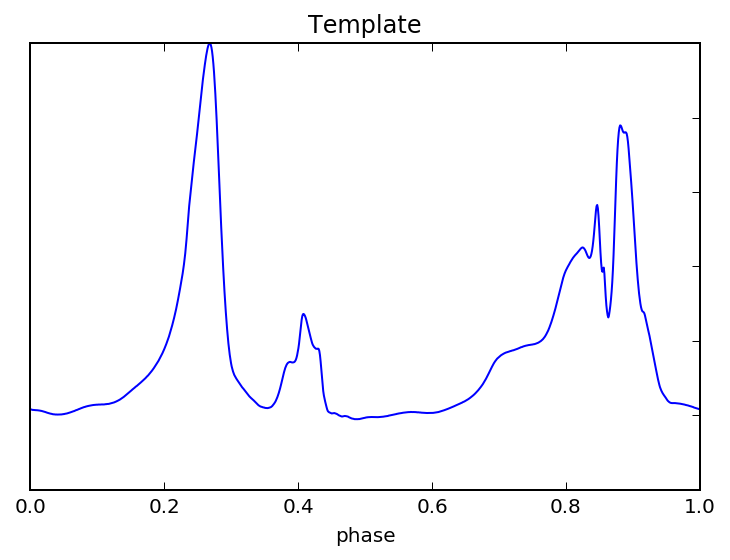

In [3]:
T = psrchive.Archive_load(template)
T.dedisperse()
T.pscrunch()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_values /= np.amax(t_values)
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values)[1])/(2*np.pi)
t_values = pipe.rotate_phase(t_values, -a) 
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
plt.plot(t_phases,t_values)
plt.title("Template")
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")

In [28]:
start_mjd = None
dynamic_spectrum = []
for f in sorted(glob(join(observation,processing_name,"zap_*.ar"))):
    F = psrchive.Archive_load(f)
    F.pscrunch()
    F.dedisperse()
    F.remove_baseline()
    d = F.get_data()[:,0,:,:]
    w = F.get_weights()[:,:]

    if start_mjd is None:
        start_mjd = F.start_time().in_days()
    nchan = d.shape[1]
    bw = F.get_bandwidth()
    center_frequency = F.get_centre_frequency()

    # Get a properly aligned template for amplitude estimation
    # Could just use dprof I suppose, with appropriate normalization
    dprof = (d*w[...,None]).sum(axis=0).sum(axis=0)
    phase = pipe.align_profile(t_values, dprof)
    tz = pipe.rotate_phase(t_values,phase)
    tz -= tz.mean()
    
    d -= d.mean(axis=-1)[...,None]
    j = np.sum(d*tz[None,None,:], axis=-1)
    j = np.ma.array(j)
    j[w==0] = np.ma.masked
    dynamic_spectrum.append(j)
end_mjd = F.end_time().in_days()

In [29]:
(end_mjd,start_mjd)

(56412.99963454201, 56412.52547254797)

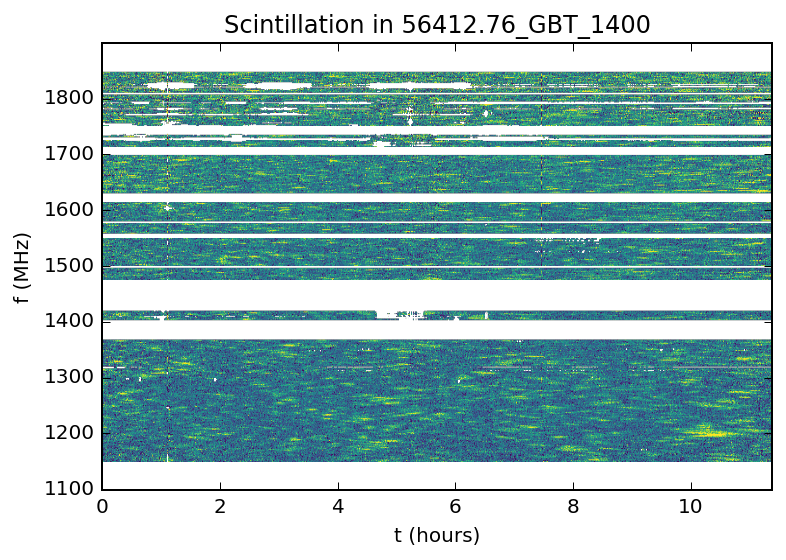

In [30]:
ds = np.ma.concatenate(dynamic_spectrum)
vmin,vmax = np.percentile(ds.compressed(),[1,99])
plt.imshow(ds.T, 
           extent=(0,(end_mjd-start_mjd)*24,center_frequency-bw/2,center_frequency+bw/2),
           vmin=vmin, vmax=vmax)
plt.xlabel("t (hours)")
plt.ylabel("f (MHz)")
plt.title("Scintillation in %s" % os.path.split(observation)[-1])
plt.gca().set_aspect('auto')
plt.savefig("scintillation.pdf")

We want to look at the autocorrelation of this dynamic spectrum. That is, we have a dynamic spectrum consisting of intensity measurements $d_{ij}$ and weight measurements $w_{ij}$ (which we simply treat as zero for illegal $i$ and $j$). The autocorrelation, assuming we want equal spacing in the frequency direction, is given by
$$
C_{kl} = \frac{\sum_{i,j} d_{ij}d_{i+k,j+l}w_{ij}w_{i+k,j+l}}{\sum_{i,j}w_{ij}w_{i+k,j+l}}.
$$
But these can be written as 2D convolutions (of suitably zero-padded objects),
$$
C = \frac{(dw)*(dw)}{w*w},
$$
and therefore we can compute the autocorrelation using FFTs.

Now, I note that using standard assumptions about scintillation, the scintle bandwidth should grow like $f^4$ (or maybe $4.4$ or $3.97$), so really we shouldn't be adding the one-channel correlations from the top of the band in the same category as the one-channel correlations from the bottom of the band. We could instead define a rescaled frequency axis by taking the fourth root of frequency and accumulate measurements into bins along this axis.

Also worth remembering, the cross-correlation works much better if the means are all zero.